In [1]:
# coding:utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, metrics
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder


# pandas
import pandas as pd
pd.set_option('display.max_rows', 500)

# LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 交差検証
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# AUC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
purchase_df = pd.read_csv('../input/purchase_record.csv')
user_df = pd.read_csv('../input/user_info.csv')
test_df = pd.read_csv('../input/purchase_record_test.csv')

In [3]:
purchase_df.shape

(1803574, 14)

In [4]:
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803574 entries, 0 to 1803573
Data columns (total 14 columns):
user_id        object
purchase_id    object
date           object
product_id     object
parts_1        object
parts_2        object
parts_3        object
parts_4        object
parts_5        object
parts_6        object
parts_7        object
parts_8        object
parts_9        object
purchase       int64
dtypes: int64(1), object(13)
memory usage: 192.6+ MB


In [5]:
purchase_df.head()

,user_id,purchase_id,date,product_id,parts_1,parts_2,parts_3,parts_4,parts_5,parts_6,parts_7,parts_8,parts_9,purchase
0,uid_100,pid_0000000000,2017-09-27,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,uid_100,pid_0000000001,2017-09-27,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,uid_100002,pid_0000000002,2017-11-23,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,uid_100002,pid_0000000003,2017-11-23,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,uid_100003,pid_0000000004,2018-02-07,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [6]:
purchase_df.fillna(0, inplace=True)

In [7]:
purchase_df.purchase.value_counts()

0    928044
1    875530
Name: purchase, dtype: int64

In [8]:
user_df.shape

(189114, 32)

In [9]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189114 entries, 0 to 189113
Data columns (total 32 columns):
user_id         189114 non-null object
date            189114 non-null object
attribute_1     189114 non-null object
attribute_2     189114 non-null object
attribute_3     189114 non-null object
attribute_4     189114 non-null bool
attribute_5     189114 non-null bool
attribute_6     189114 non-null bool
attribute_7     189114 non-null bool
attribute_8     189114 non-null bool
attribute_9     189114 non-null bool
attribute_10    189114 non-null bool
attribute_11    189114 non-null bool
attribute_12    189114 non-null bool
attribute_13    189114 non-null bool
attribute_14    189114 non-null bool
attribute_15    189114 non-null bool
attribute_16    189114 non-null bool
attribute_17    189114 non-null bool
attribute_18    189114 non-null bool
attribute_19    189114 non-null bool
attribute_20    189114 non-null bool
attribute_21    189114 non-null bool
attribute_22    189114 non-n

In [10]:
user_df.head()

,user_id,date,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,...,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30
0,uid_100,2016-06-29,id 5,id 5,id 5,True,False,False,True,True,...,True,False,True,True,False,False,True,True,True,False
1,uid_100002,2016-01-06,id 28,id 9,id 5,False,False,True,True,False,...,False,False,True,True,True,True,True,True,True,False
2,uid_100003,2017-06-10,id 4,id 8,id 5,True,True,True,True,True,...,True,False,False,True,True,True,True,False,True,True
3,uid_100004,2017-07-20,id 40,id 25,id 9,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,uid_100006,2017-07-27,id 40,id 25,id 9,False,False,False,False,False,...,False,False,False,True,False,False,False,True,True,False


In [11]:
train_df = pd.merge(purchase_df, user_df, how='left', on='user_id')

In [12]:
train_df.head()

,user_id,purchase_id,date_x,product_id,parts_1,parts_2,parts_3,parts_4,parts_5,parts_6,...,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30
0,uid_100,pid_0000000000,2017-09-27,product 2,0,0,0,0,0,0,...,True,False,True,True,False,False,True,True,True,False
1,uid_100,pid_0000000001,2017-09-27,product 2,0,0,0,0,0,0,...,True,False,True,True,False,False,True,True,True,False
2,uid_100002,pid_0000000002,2017-11-23,product 2,0,0,0,0,0,0,...,False,False,True,True,True,True,True,True,True,False
3,uid_100002,pid_0000000003,2017-11-23,product 2,0,0,0,0,0,0,...,False,False,True,True,True,True,True,True,True,False
4,uid_100003,pid_0000000004,2018-02-07,product 2,0,0,0,0,0,0,...,True,False,False,True,True,True,True,False,True,True


In [13]:
# train_dfから不要列を削除する
# train_df = train_df.drop('date_x', axis=1)
train_df = train_df.drop('date_y', axis=1)
# train_df = train_df.drop('product_id', axis=1)
train_df = train_df.drop('user_id', axis=1)

In [14]:
train_df.head()

,purchase_id,date_x,product_id,parts_1,parts_2,parts_3,parts_4,parts_5,parts_6,parts_7,...,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30
0,pid_0000000000,2017-09-27,product 2,0,0,0,0,0,0,0,...,True,False,True,True,False,False,True,True,True,False
1,pid_0000000001,2017-09-27,product 2,0,0,0,0,0,0,0,...,True,False,True,True,False,False,True,True,True,False
2,pid_0000000002,2017-11-23,product 2,0,0,0,0,0,0,0,...,False,False,True,True,True,True,True,True,True,False
3,pid_0000000003,2017-11-23,product 2,0,0,0,0,0,0,0,...,False,False,True,True,True,True,True,True,True,False
4,pid_0000000004,2018-02-07,product 2,0,0,0,0,0,0,0,...,True,False,False,True,True,True,True,False,True,True


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1803574 entries, 0 to 1803573
Data columns (total 43 columns):
purchase_id     object
date_x          object
product_id      object
parts_1         object
parts_2         object
parts_3         object
parts_4         object
parts_5         object
parts_6         object
parts_7         object
parts_8         object
parts_9         object
purchase        int64
attribute_1     object
attribute_2     object
attribute_3     object
attribute_4     bool
attribute_5     bool
attribute_6     bool
attribute_7     bool
attribute_8     bool
attribute_9     bool
attribute_10    bool
attribute_11    bool
attribute_12    bool
attribute_13    bool
attribute_14    bool
attribute_15    bool
attribute_16    bool
attribute_17    bool
attribute_18    bool
attribute_19    bool
attribute_20    bool
attribute_21    bool
attribute_22    bool
attribute_23    bool
attribute_24    bool
attribute_25    bool
attribute_26    bool
attribute_27    bool
attribute_28    

In [16]:
train_df.shape

(1803574, 43)

In [17]:
train_df.isnull().sum().sum()

0

In [18]:
# %%time
# pdp.ProfileReport(train_df)

In [19]:
test_df = pd.merge(test_df, user_df, how='left', on='user_id')

In [20]:
test_df.shape

(215041, 44)

In [21]:
# sample_train_df = train_df.sample(n=len(train_df)//500)

In [22]:
# sample_test_df = test_df.sample(n=len(test_df)//500)

In [23]:
# train_df = sample_train_df
# test_df = sample_test_df

In [24]:
# test_dfから不要列を削除する
# test_df = test_df.drop('date_x', axis=1)
test_df = test_df.drop('date_y', axis=1)
# test_df = test_df.drop('product_id', axis=1)
test_df = test_df.drop('user_id', axis=1)

In [25]:
test_df.head()

,purchase_id,date_x,product_id,parts_1,parts_2,parts_3,parts_4,parts_5,parts_6,parts_7,...,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30
0,pid_0001803575,2018-08-26,product 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,True,True,False,False,True,True,True,False
1,pid_0001803576,2018-08-04,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,True,True,False,False,True,True,True,False
2,pid_0001803577,2018-08-26,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,True,True,False,False,True,True,True,False
3,pid_0001803578,2018-08-04,product 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,True,True,False,False,True,True,True,False
4,pid_0001803579,2018-08-02,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,True,True,True,True,False,True,True


In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1803574 entries, 0 to 1803573
Data columns (total 43 columns):
purchase_id     object
date_x          object
product_id      object
parts_1         object
parts_2         object
parts_3         object
parts_4         object
parts_5         object
parts_6         object
parts_7         object
parts_8         object
parts_9         object
purchase        int64
attribute_1     object
attribute_2     object
attribute_3     object
attribute_4     bool
attribute_5     bool
attribute_6     bool
attribute_7     bool
attribute_8     bool
attribute_9     bool
attribute_10    bool
attribute_11    bool
attribute_12    bool
attribute_13    bool
attribute_14    bool
attribute_15    bool
attribute_16    bool
attribute_17    bool
attribute_18    bool
attribute_19    bool
attribute_20    bool
attribute_21    bool
attribute_22    bool
attribute_23    bool
attribute_24    bool
attribute_25    bool
attribute_26    bool
attribute_27    bool
attribute_28    

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215041 entries, 0 to 215040
Data columns (total 42 columns):
purchase_id     215041 non-null object
date_x          215041 non-null object
product_id      215041 non-null object
parts_1         21006 non-null object
parts_2         21006 non-null object
parts_3         21006 non-null object
parts_4         21006 non-null object
parts_5         21006 non-null object
parts_6         21006 non-null object
parts_7         21006 non-null object
parts_8         21006 non-null object
parts_9         21006 non-null object
attribute_1     215041 non-null object
attribute_2     215041 non-null object
attribute_3     215041 non-null object
attribute_4     215041 non-null bool
attribute_5     215041 non-null bool
attribute_6     215041 non-null bool
attribute_7     215041 non-null bool
attribute_8     215041 non-null bool
attribute_9     215041 non-null bool
attribute_10    215041 non-null bool
attribute_11    215041 non-null bool
attribute_12    2

In [28]:
%%time
# train = pd.get_dummies(train_df, drop_first=True)
train = pd.get_dummies(train_df, columns=['product_id', 'date_x', 'attribute_1', 'attribute_2', 'attribute_3', 'parts_1', 'parts_2', 'parts_3', 'parts_4', 'parts_5', 'parts_6', 'parts_7', 'parts_8', 'parts_9'], drop_first=True)
train = train * 1
train = train.set_index('purchase_id')
# train = pd.get_dummies(train_df, columns!=['purchase_id', 'purchase'], drop_first=True)



CPU times: user 9.21 s, sys: 2.89 s, total: 12.1 s
Wall time: 13 s


In [29]:
%%time
# test = pd.get_dummies(test_df, drop_first=True)
#test = pd.get_dummies(test_df, drop_first=True)
test = pd.get_dummies(test_df, columns=['product_id', 'date_x', 'attribute_1', 'attribute_2', 'attribute_3', 'parts_1', 'parts_2', 'parts_3', 'parts_4', 'parts_5', 'parts_6', 'parts_7', 'parts_8', 'parts_9'], drop_first=True)
test = test * 1
test = test.set_index('purchase_id')

CPU times: user 481 ms, sys: 121 ms, total: 602 ms
Wall time: 613 ms


In [30]:
train.head()

,purchase,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,...,parts_9_id 18,parts_9_id 19,parts_9_id 2,parts_9_id 3,parts_9_id 4,parts_9_id 5,parts_9_id 6,parts_9_id 7,parts_9_id 8,parts_9_id 9
purchase_id,,,,,,,,,,,,,,,,,,,,,
pid_0000000000,0,1,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0000000001,0,1,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0000000002,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
pid_0000000003,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
pid_0000000004,1,1,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1803574 entries, pid_0000000000 to pid_0001803573
Columns: 612 entries, purchase to parts_9_id 9
dtypes: int64(28), uint8(584)
memory usage: 1.4+ GB


In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215041 entries, pid_0001803575 to pid_0002018615
Columns: 296 entries, attribute_4 to parts_9_id 9
dtypes: int64(27), uint8(269)
memory usage: 101.1+ MB


In [33]:
# data_yに目的変数を代入
y_train = train['purchase']

# data_yの表示
print( y_train )

# data_Xに説明変数を代入
X_train = train.drop('purchase', axis=1)

# data_Xの表示
print( X_train )

purchase_id
pid_0000000000    0
pid_0000000001    0
pid_0000000002    1
pid_0000000003    1
pid_0000000004    1
                 ..
pid_0001803569    1
pid_0001803570    1
pid_0001803571    1
pid_0001803572    1
pid_0001803573    1
Name: purchase, Length: 1803574, dtype: int64
                attribute_4  attribute_5  attribute_6  attribute_7  \
purchase_id                                                          
pid_0000000000            1            0            0            1   
pid_0000000001            1            0            0            1   
pid_0000000002            0            0            1            1   
pid_0000000003            0            0            1            1   
pid_0000000004            1            1            1            1   
...                     ...          ...          ...          ...   
pid_0001803569            1            1            1            1   
pid_0001803570            1            1            1            1   
pid_0001803571        

fold1 start
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	training's binary_logloss: 0.562513	valid_1's binary_logloss: 0.562669
oof: [0.76145921 0.76055893 0.34314092 ... 0.70863431 0.76096951 0.71779941]
AUC: [0.7818775079272904]
fold1 end

fold2 start
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	training's binary_logloss: 0.563967	valid_1's binary_logloss: 0.565416
oof: [0.7422087  0.78687128 0.78687128 ... 0.7227226  0.72104342 0.72104342]
AUC: [0.7818775079272904, 0.7783293346365021]
fold2 end

fold3 start
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	training's binary_logloss: 0.563337	valid_1's binary_logloss: 0.565173
oof: [0.7601797  0.75857088 0.77434604 ... 0.7211511  0.70503988 0.69102289]
AUC: [0.7818775079272904, 0.7783293346365021, 0.7792740192491804]
fold3 end

fold

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


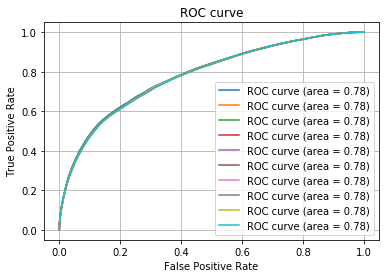

In [34]:
%%time
# 10分割交差検証を指定し、インスタンス化
n_splits = 10
kf = KFold(n_splits, shuffle=True)

# スコアとモデルを格納するリスト
score_list = []
models = []

for fold_, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print(f'fold{fold_ + 1} start')
    train_x = X_train.iloc[train_index]
    valid_x = X_train.iloc[valid_index]
    train_y = y_train[train_index]
    valid_y = y_train[valid_index]
    # lab.Datasetを使って,trainとvalidを作っておく
    lgb_train= lgb.Dataset(train_x, train_y)
    lgb_valid = lgb.Dataset(valid_x, valid_y)

    # パラメータを定義
    lgbm_params = {'objective': 'binary'}                                                                                               
          
    # 学習
    gbm = lgb.train(params = lgbm_params,
                    train_set = lgb_train, 
                    num_boost_round = 200,
                    valid_sets = [lgb_train, lgb_valid],
                    early_stopping_rounds = 20,
                    verbose_eval = -1 # 学習の状況を表示しない
                   )

    oof = gbm.predict(valid_x)
    print('oof:', oof)
    # AUC算出
    # auc = metrics.auc(valid_y, oof)
    auc = roc_auc_score(valid_y, oof)
    score_list.append(auc) # スコアリストに保存
    # score_list.append(np.sqrt(mean_squared_error(valid_y, oof))) #RMSEを出す
    # score_list.append(round(accuracy_score(valid_y, oof)*100,2)) # 正解率Accuracyを出す。(検証用y, 予測結果)
    print('AUC:', score_list)
    models.append(gbm) # 学習が終わったモデルをリストに入れておく
    print(f'fold{fold_ + 1} end\n' )
    
    # FPR, TPR(, しきい値) を算出
    fpr, tpr, thresholds = metrics.roc_curve(valid_y, oof)
    
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    
print(score_list, '平均score', round(np.mean(score_list), 2))

In [35]:
# 比較
# p = pd.DataFrame({"actual":valid_y,"pred":oof})
# p.plot(figsize=(15,4))
# print("AUC",round(np.mean(score_list), 2))

In [36]:
# テストデータの予測を格納する。テストデータ列数*分割数列のnumpy行列を作成
test_pred = np.zeros((len(test), n_splits))

for fold_, gbm in enumerate(models):
    pred_ = gbm.predict(test) # testを予測
    test_pred[:, fold_] = pred_

result = pd.DataFrame({
    'purchase_id': test.index.values,
    'probability': np.mean(test_pred, axis=1)
})
result.to_csv('../output/submit.csv',header=False,index=False)

In [38]:
import datetime
dt_now = datetime.datetime.now()
print(dt_now)
print("予測完了")

2019-11-19 23:50:20.171818
予測完了
